# Cancer Detection using Convolutional Neural Networks

## Introduction

Medical imaging is becoming one of the major applications of machine learning. Deep learning converts the clinically-relevant task of metastasis detection into a straight-forward binary image classification task (disease or no disease). The notebook trains a convolutional neural network to identify metastatic cancer in small image patches taken from larger digital pathology scans.



Convolutional neural networks (ConvNets) have proved very successful in solving image classification problems. Typical neural networks do not scale well to full images. For example, an image  of size 32x32x3 (32 wide, 32 high, 3 color channels) would have 32x32x3 = 3072 weights and inputs to a single fully-connected neuron in a first hidden layer. This amount seems manageable, but if we apply the regular neural net to an larger image, e.g. 200x200x3, this lead to neurons that have 200x200x3 = 120,000 weights. Moreover, we would almost certainly want to have several such neurons, so the parameters would add up quickly! Clearly, this full connectivity is wasteful and the huge number of parameters would quickly lead to overfitting.



ConvNet architectures minimizes the number of parameters while still managing to extract the local and global structures from image data. Unlike a regular neural network, the layers of a ConvNet have neurons arranged in 3 dimensions (width, height, depth). Every layer of a ConvNet transforms the 3D input volume to a 3D output volume of neuron activations through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular neural networks).



**The Dataset**



PatchCamelyon (PCam) is a benchmarking dataset consisting color images of size (96 x 96 pixels) extracted from histopathologic scans of lymph node sections. Each image in the dataset is a small patch extracted from histopathologic scans of lymph node sections. The dataset is structured to facilitate the training and evaluation of supervised machine learning models for detecting metastatic cancer. Kaggle's version of the PatchCamelyon (PCam) dataset is divided into a training set of of 220,025 examples and test set of 57,458 examples. Each image in the training set is annoted with an image id. A separate file containing a binary label indicating presence of metastatic tissue is also available. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. [Histopathological Cancer Detection dataset](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data)

## Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

# Part 2: Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os

# Create a directory for Kaggle
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to the directory
!mv kaggle.json /root/.kaggle/

# Change the permissions of the file
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:30<00:00, 223MB/s]
100% 6.31G/6.31G [00:30<00:00, 224MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('data')  # Extract to 'data' folder

In [ ]:
# Define the relative path to the file
train_img_path = os.path.join(os.getcwd(), 'data', 'train')
test_img_path = os.path.join(os.getcwd(),  'data', 'test')
labels_path = os.path.join(os.getcwd(),  'data', 'train_labels.csv')

In [2]:
# Kaggle Notebook environment
# Define the relative path to the file
input_path = '/kaggle/input/histopathologic-cancer-detection'
train_img_path = os.path.join(input_path, 'train')
test_img_path = os.path.join(input_path, 'test')
labels_path = os.path.join(input_path, 'train_labels.csv')


### The Training Labels

The 'train_labels' file contains 220,025 examples. The dataset is not balanced, meaning there is an unequal number of examples for the two binary classes: no mestasis (0) and mestasis (1). Given that there are more negative examples making up 60% of the data, this might bias the model.

In [3]:
train_labels = pd.read_csv(labels_path)
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
train_labels.isnull().sum()

id       0
label    0
dtype: int64

In [11]:
total_labels = np.sum(train_labels.label.value_counts())
negative_count = train_labels.label.value_counts()[0]
positive_count = train_labels.label.value_counts()[1]

percent_negative = (negative_count / total_labels) * 100
percent_positive = (positive_count / total_labels) * 100

print(f"Total Number of Examples: {total_labels}")
print(f"Percent Negative Label: {percent_negative:.2f}%")
print(f"Percent Positive Label: {percent_positive:.2f}%")

Total Number of Examples: 220025
Percent Negative Label: 59.50%
Percent Positive Label: 40.50%


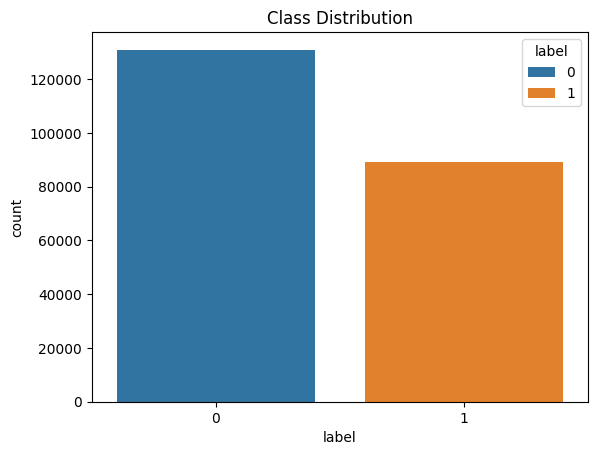

In [ ]:
sns.countplot(x='label', data=train_labels, hue = 'label')

plt.title('Class Distribution')

plt.show()

### The Image Files

There are 220,025 images in the training dataset and 57,458 images in the test dataset.

In [ ]:
def count_tif_files(directory):

    # List all files in the directory
    files = os.listdir(directory)

    # Filter for .tif files
    tif_files = [f for f in files if f.lower().endswith('.tif')]

    return len(tif_files)

num_train_tif_files = count_tif_files(train_img_path )
num_test_tif_files = count_tif_files(test_img_path)

print(f"Number of .tif training files: {num_train_tif_files}")
print(f"Number of .tif test files: {num_test_tif_files}")

Number of .tif training files: 220025
Number of .tif test files: 57458


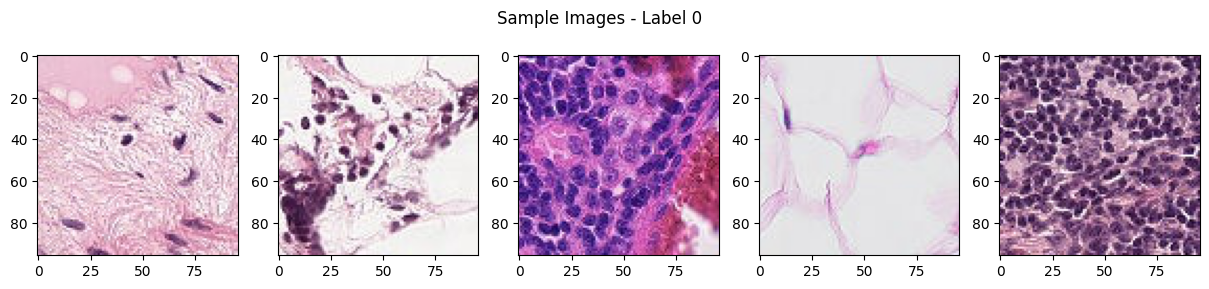

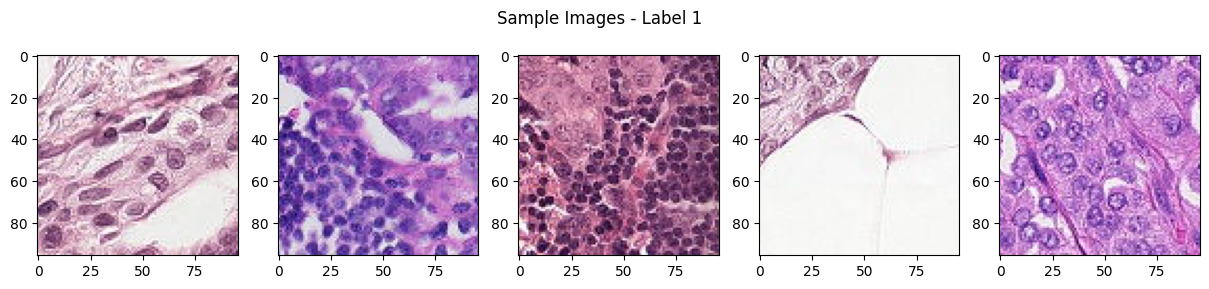

In [ ]:
from PIL import Image

def sample_images(label, num_samples = 5):
    samples = train_labels[train_labels['label'] == label].sample(num_samples)
    plt.figure(figsize=(15,3))

    for idx, img_id in enumerate(samples['id']):
        img_path = os.path.join(train_img_path, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(img)
    plt.suptitle(f'Sample Images - Label {label}')
    plt.show()

sample_images(label=0)
sample_images(label=1)

# Part 3: ConvNet Model Architecture

A simple ConvNet architecture for image classification follows the architecture [ INPUT - CONV - RELU - POOL - FC ].



- INPUT of the network is the raw pixel values from each image, in this case an image of width 96, height 96, and with three color channels R,G,B.



- The CONV layer serves as an automated feature extraction process. The process to invlolves convoluting small areas of the input volume  with a Kernal matrix and then taking the sum of the convolved matrices and adding a bias term to each element of the resulting matrix. The kernel size is typically 3 x 3 pixels and the number of output channels vary depending on empirical findings. If we decide to use 3 X 3 filter and 16 output channels this would result with an output of size [94x94x16].



- RELU layer will apply the max(0,x) activation function, introducing non-linearity in the feature extraction process, allowing the neural network to learn complex (non-linear) patterns and relationships within the data. This process leaves the size of the volume from previous steps unchanged ([94x94x16]).



- POOL layer will perform an operation that further reduces the dimensionality of input. A filter, typically of size [2x2], is overlayed over local regions of image volume and combines them by sampling the max or average values of all neighboring elements. This results in volume such as [47x47x16] if we decide to use stride of 2.



- FC (i.e. fully-connected) layer refers to the regular neural network that can perform classification of an image into a group. In this case there are 2 categories in the PCam dataset (metastatic  or not metastatic).


The neural network architecture and hyperparameters tested in this project, are modeled from investigators who classified normalized lung image patches because these images are similar in structure to the PCam dataset which contains small image patches from lymph nodes. See the article [here](https://ieeexplore.ieee.org/document/7064414).



They propose the following design: The first layer is a convolutional layer with kernel size of 7 × 7 pixels and 16 output channels. The second layer is a max pooling layer with 2×2 kernel size. The following three layers are fully connected neural layers with 100-50-5 neurons in each layer respectively.



To improve perfomance, they investigators used a learning rate of 0.001, momentum rate of 0.9, and decay rate of 0.01. They also processed 128 input samples in batches and applied dropout with rate of 0.6.



The decision to use a single convolutional layer in the architecture design was based on the intrinsic structure of the images. According to the authors, the input patches are textures-like images which do not have obvious large scale or high level features for the network to learn. Therefore, a network with a single convolutional layer performs as good as networks with multiple convolution layers in lung image patch classification task. They chose this simpler network architecture because it greatly reduced the number of parameters to be learned, which helps to avoid the over-fitting problem



I will implement simple neural network architecture [INPUT - CONV - RELU - POOL - FC] and compare with multiple convolution layers. I will also test the 7 * 7 kernal size against the commonly used size 3 x3. I will also test various filter number (16, 32, 64), number of neurons in the FC layer, and number of FC layers. 


In [4]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'], random_state=42)

# Convert labels to strings
y_train['label'] = y_train['label'].astype(str)
y_test['label'] = y_test['label'].astype(str)

# Create a new 'filename' column by adding '.tif' extension
y_train['filename'] = y_train['id'] + '.tif'
y_test['filename'] = y_test['id'] + '.tif'

In [5]:
y_test.head()

,id,label,filename
97957,de403e6cdaf463393843e70470d8c8bf178fd14b,0,de403e6cdaf463393843e70470d8c8bf178fd14b.tif
47898,6faf991f734761db40db535c5ae5117863422156,0,6faf991f734761db40db535c5ae5117863422156.tif
210426,b2a9ab2553eb6597fea0f93dd94a301f58f5f99f,0,b2a9ab2553eb6597fea0f93dd94a301f58f5f99f.tif
179266,377087796f7736a637e8178d97dde43d1058345c,0,377087796f7736a637e8178d97dde43d1058345c.tif
165580,20a68d59cb82be2b2d8c24d0d43c6787c6fd1f46,0,20a68d59cb82be2b2d8c24d0d43c6787c6fd1f46.tif


In [6]:
# Data Generators

train_ImageDataGenerator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

val_ImageDataGenerator = ImageDataGenerator(rescale=1./255)

train_generator = train_ImageDataGenerator.flow_from_dataframe(
    dataframe=y_train,
    directory=train_img_path,
    x_col='filename',  # Use the new 'filename' column
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_ImageDataGenerator.flow_from_dataframe(
    dataframe=y_test,
    directory=train_img_path,
    x_col='filename',  # Use the new 'filename' column
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [17]:
def gen_to_dataset(generator):

    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = gen_to_dataset(train_generator)
val_dataset = gen_to_dataset(val_generator)

## Define the Model

In [8]:
#fitting the model
num_train_samples = 176020  # Total number of training samples
num_val_samples = 44005    # Total number of validation samples
global_batch_size = 32   #Batch Size

steps_per_epoch = num_train_samples // global_batch_size
validation_steps = num_val_samples // global_batch_size

In [ ]:
#defining model using suggested archictecture from literature

with strategy.scope():
    model=Sequential()

    model.add(Input(shape=(96, 96, 3)))

    #adding convolution layer
    model.add(Conv2D(16,(7, 7), activation = 'relu'))

    #adding pooling layer
    model.add(MaxPooling2D(2,2))

    #adding fully connected layer
    model.add(Flatten())
    model.add(Dense(100,activation = 'relu'))
    model.add(Dense(50,activation = 'relu'))
    model.add(Dense(5,activation = 'relu'))

    #adding output layer
    model.add(Dense(1,activation = 'sigmoid'))

    #compiling the model
    model.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate = 0.01, ema_momentum = 0.9, weight_decay = 0.01),
              metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, epochs=5, validation_data=val_dataset, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/5
1375/1375 [==============================] - 190s 132ms/step - loss: 0.7164 - accuracy: 0.5946 - val_loss: 0.6751 - val_accuracy: 0.5950
Epoch 2/5
1375/1375 [==============================] - 176s 126ms/step - loss: 0.6752 - accuracy: 0.5950 - val_loss: 0.6750 - val_accuracy: 0.5951
Epoch 3/5
1375/1375 [==============================] - 175s 127ms/step - loss: 0.6752 - accuracy: 0.5949 - val_loss: 0.6755 - val_accuracy: 0.5950
Epoch 4/5
1375/1375 [==============================] - 173s 126ms/step - loss: 0.6752 - accuracy: 0.5950 - val_loss: 0.6755 - val_accuracy: 0.5948
Epoch 5/5
1375/1375 [==============================] - 177s 129ms/step - loss: 0.6752 - accuracy: 0.5949 - val_loss: 0.6753 - val_accuracy: 0.5950


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 35344)             0         
                                                                 
 dense (Dense)               (None, 100)               3534500   
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                        

In [ ]:
# Evaluating the model on the validation dataset
loss, accuracy = model.evaluate(val_dataset, steps=validation_steps)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

343/343 [==============================] - 32s 91ms/step - loss: 0.6754 - accuracy: 0.5948
Validation Loss: 0.6754
Validation Accuracy: 0.5948


The suggested architecture has low accuracy. I tested a max of 10 epochs in other tries and still arrived at validation accuracy around 0.59.

## Hyperparameter Tuning

### Model 1

In [ ]:
### Hyperparams

output_channels = 16
dense_units_1 = 100
dense_units_2 = 50
drop_rate = 0.1
learning_rate =  0.01

with strategy.scope():
    model = Sequential()
    model.add(Input(shape=(96, 96, 3)))

    model.add(Conv2D(output_channels, kernel_size=3,strides=1,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
   
    model.add(Flatten())
    model.add(Dense(dense_units_1, activation='relu'))
    model.add(Dense(dense_units_2, activation='relu'))
    model.add(Dropout(rate = drop_rate))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=learning_rate),
            metrics=['accuracy'])


In [ ]:
history1 = model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                     validation_steps=validation_steps)

Epoch 1/5
1375/1375 [==============================] - 179s 124ms/step - loss: 0.7001 - accuracy: 0.6114 - val_loss: 0.5706 - val_accuracy: 0.6943
Epoch 2/5
1375/1375 [==============================] - 167s 121ms/step - loss: 0.5617 - accuracy: 0.7103 - val_loss: 0.5414 - val_accuracy: 0.7286
Epoch 3/5
1375/1375 [==============================] - 177s 129ms/step - loss: 0.5340 - accuracy: 0.7336 - val_loss: 0.5144 - val_accuracy: 0.7497
Epoch 4/5
1375/1375 [==============================] - 179s 130ms/step - loss: 0.5178 - accuracy: 0.7469 - val_loss: 0.5098 - val_accuracy: 0.7492
Epoch 5/5
1375/1375 [==============================] - 182s 132ms/step - loss: 0.5082 - accuracy: 0.7545 - val_loss: 0.5345 - val_accuracy: 0.7359


In [ ]:
loss, accuracy1 = model.evaluate(val_dataset, steps=validation_steps)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy1:.4f}')

343/343 [==============================] - 41s 96ms/step - loss: 0.7072 - accuracy: 0.4258
Validation Loss: 0.7072
Validation Accuracy: 0.4258


### Model 2

In [ ]:
# Deeper dense layers
output_channels = 16
dense_units_1 = 256
dense_units_2 = 128
drop_rate = 0.3
learning_rate =  0.001

with strategy.scope():
    model = Sequential()

    model.add(Input(shape=(96, 96, 3)))
    model.add(Conv2D(output_channels, kernel_size=3,strides=1,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units_1, activation='relu'))
    model.add(Dense(dense_units_2, activation='relu'))
    model.add(Dropout(rate = drop_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=learning_rate),
            metrics=['accuracy'])

In [ ]:
history2 = model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Epoch 1/5
1375/1375 [==============================] - 177s 123ms/step - loss: 0.4777 - accuracy: 0.7844 - val_loss: 0.4485 - val_accuracy: 0.7956
Epoch 2/5
1375/1375 [==============================] - 163s 119ms/step - loss: 0.4270 - accuracy: 0.8062 - val_loss: 0.4169 - val_accuracy: 0.8132
Epoch 3/5
1375/1375 [==============================] - 162s 118ms/step - loss: 0.4075 - accuracy: 0.8173 - val_loss: 0.3970 - val_accuracy: 0.8218
Epoch 4/5
1375/1375 [==============================] - 171s 124ms/step - loss: 0.3898 - accuracy: 0.8256 - val_loss: 0.3828 - val_accuracy: 0.8277
Epoch 5/5
1375/1375 [==============================] - 181s 132ms/step - loss: 0.3768 - accuracy: 0.8324 - val_loss: 0.3786 - val_accuracy: 0.8322


In [ ]:
loss, accuracy2 = model.evaluate(val_dataset, steps=validation_steps)



print(f'Validation Loss: {loss:.4f}')

print(f'Validation Accuracy: {accuracy2:.4f}')

343/343 [==============================] - 33s 95ms/step - loss: 0.3785 - accuracy: 0.8322
Validation Loss: 0.3785
Validation Accuracy: 0.8322


### Model 3

In [ ]:
output_channels_1 = 32
output_channels_2 = 16
dense_units_1 = 256
drop_rate = 0.3
learning_rate =  0.001

with strategy.scope():
    model = Sequential()
    
    model.add(Input(shape=(96, 96, 3)))
    model.add(Conv2D(output_channels_1,kernel_size=3,strides=1, activation='relu'))
    model.add(Conv2D(output_channels_2,kernel_size=3,strides=1, activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units_1, activation='relu'))
    model.add(Dropout(rate = drop_rate))

    # Adding output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=learning_rate),
            metrics=['accuracy'])

In [ ]:
history3 = model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Epoch 1/5
1375/1375 [==============================] - 188s 130ms/step - loss: 0.4799 - accuracy: 0.7782 - val_loss: 0.4232 - val_accuracy: 0.8093
Epoch 2/5
1375/1375 [==============================] - 169s 123ms/step - loss: 0.4133 - accuracy: 0.8175 - val_loss: 0.3878 - val_accuracy: 0.8286
Epoch 3/5
1375/1375 [==============================] - 170s 124ms/step - loss: 0.3873 - accuracy: 0.8311 - val_loss: 0.3729 - val_accuracy: 0.8369
Epoch 4/5
1375/1375 [==============================] - 180s 131ms/step - loss: 0.3733 - accuracy: 0.8378 - val_loss: 0.3646 - val_accuracy: 0.8417
Epoch 5/5
1375/1375 [==============================] - 183s 133ms/step - loss: 0.3604 - accuracy: 0.8447 - val_loss: 0.3605 - val_accuracy: 0.8437


In [ ]:
loss, accuracy3 = model.evaluate(val_dataset, steps=validation_steps)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy3:.4f}')

343/343 [==============================] - 35s 99ms/step - loss: 0.3608 - accuracy: 0.8436
Validation Loss: 0.3608
Validation Accuracy: 0.8436


### Model 4

In [ ]:
output_channels_1 = 128
output_channels_2 = 64
output_channels_3 = 32
dense_units_1 = 256
dense_units_1 = 128
drop_rate = 0.3
learning_rate =  0.001

with strategy.scope():
    model = Sequential()
    
    model.add(Input(shape=(96, 96, 3)))
    model.add(Conv2D(output_channels_1,kernel_size=3,strides=1, activation='relu'))
    model.add(Conv2D(output_channels_2,kernel_size=3,strides=1, activation='relu'))
    model.add(Conv2D(output_channels_3,kernel_size=3,strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units_1, activation='relu'))
    model.add(Dense(dense_units_2, activation='relu'))
    model.add(Dropout(rate = drop_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=learning_rate),
            metrics=['accuracy'])

In [ ]:
history4 = model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Epoch 1/5
1375/1375 [==============================] - 176s 123ms/step - loss: 1.6756 - accuracy: 0.5931 - val_loss: 0.6751 - val_accuracy: 0.5949
Epoch 2/5
1375/1375 [==============================] - 164s 119ms/step - loss: 0.6749 - accuracy: 0.5955 - val_loss: 0.6751 - val_accuracy: 0.5949
Epoch 3/5
1375/1375 [==============================] - 174s 127ms/step - loss: 0.6748 - accuracy: 0.5958 - val_loss: 0.6752 - val_accuracy: 0.5947
Epoch 4/5
1375/1375 [==============================] - 164s 120ms/step - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6750 - val_accuracy: 0.5951
Epoch 5/5
1055/1375 [======================>.......] - ETA: 28s - loss: 0.6755 - accuracy: 0.5941

In [ ]:
loss, accuracy4 = model.evaluate(val_dataset, steps=validation_steps)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy4:.4f}')

## Train Best Performing Model

In the four models tested, it seems that addding the more convolutional layers improves validation accuracy. Moreover, there is positive effect in having one dense layer with many neurons. For this reason I decided to use 3 conv layers each followed by max pooling to minimize number of parameters and finish with one dense layer followed by output layer with sigmoid activation.

In [9]:

output_channels_1 = 16
output_channels_2 = 32
output_channels_3 = 64
dense_units_1 = 256
drop_rate = 0.3
learning_rate =  0.001


model = Sequential()
model.add(Input(shape=(96, 96, 3)))

model.add(Conv2D(output_channels_1,kernel_size=3,strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(output_channels_2,kernel_size=3,strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(output_channels_3,kernel_size=3,strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate = drop_rate))    

model.add(Flatten())
model.add(Dense(dense_units_1, activation='relu'))
model.add(Dropout(rate = drop_rate))

# Adding output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=learning_rate),
            metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,497 (6.34 MB)

 Trainable params: 1,662,497 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(train_generator,
                    epochs=10,
                    #steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    #validation_steps=validation_steps
                   )

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729224699.041415     127 service.cc:145] XLA service 0x7bc98c005ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729224699.041476     127 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 13:45:26 9s/step - accuracy: 0.4375 - loss: 0.6922

I0000 00:00:1729224704.090929     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1875s 339ms/step - accuracy: 0.7822 - loss: 0.4634 - val_accuracy: 0.8358 - val_loss: 0.3722
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 495s 90ms/step - accuracy: 0.8465 - loss: 0.3582 - val_accuracy: 0.8570 - val_loss: 0.3275
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 393s 71ms/step - accuracy: 0.8645 - loss: 0.3207 - val_accuracy: 0.8759 - val_loss: 0.2974
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 404s 73ms/step - accuracy: 0.8753 - loss: 0.2978 - val_accuracy: 0.8939 - val_loss: 0.2676
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 380s 69ms/step - accuracy: 0.8803 - loss: 0.2882 - val_accuracy: 0.8949 - val_loss: 0.2571
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 392s 71ms/step - accuracy: 0.8870 - loss: 0.2771 - val_accuracy: 0.8959 - val_loss: 0.2557
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 455s 83ms/step - accuracy: 0.8926 - loss: 0.2672 - val_accuracy: 0.8995 - val_loss: 0.2478
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 472s 86ms/step - accuracy: 0.8927 - 

In [14]:
loss, accuracy = model.evaluate(val_generator, steps=validation_steps)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 109s 79ms/step - accuracy: 0.9097 - loss: 0.2362
Validation Loss: 0.2349
Validation Accuracy: 0.9087


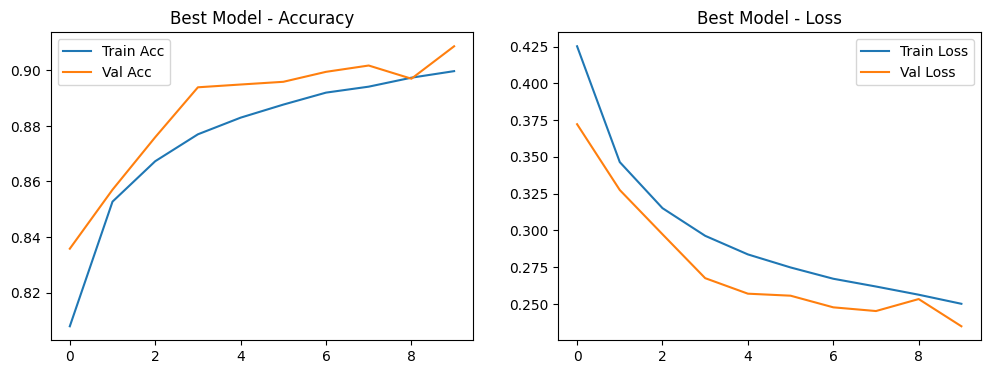

In [15]:
# Helper function for plotting

def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history, "Best Model")

## Predict on Unseen Data

In [28]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_img_path,
    x_col='id',
    y_col=None,
    target_size=(96,96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Prepare the submission DataFrame
filenames = test_generator.filenames
test_img = [filename.split('.')[0] for filename in filenames]

Found 57458 validated image filenames.


In [30]:
# Make predictions using the new
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = (predictions > 0.5).astype(int)

# Display the predictions
print('Prediction Probabilities:', predictions.flatten())
print('Predicted Classes:', predicted_classes.flatten())

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 437s 243ms/step
Prediction Probabilities: [0.7931611  0.02129658 0.297449   ... 0.08391104 0.00975891 0.77276665]
Predicted Classes: [1 0 0 ... 0 0 1]


# Part 4: Data Submission to Kaggle

In [34]:
# Create submission file as csv
output_path = os.path.join(os.getcwd(), 'submission_file.csv')

submission_file = pd.DataFrame({'id': test_img['id'],
                                'label': predicted_classes.flatten()})

submission_file.to_csv(output_path, index = False)

# PART 5: Results and Analysis

The best performing model achieved validation accuracy of 0.9087. Analyzing the accuracy and loss metrics across epochs, the validation dataset consistently outperformed the training set. This indicates that the model generalizes well and does not exhibit signs of overfitting.

However, the final result showed an AUC score of 0.5. This discrepancy likely stemmed from an error in extracting file names from the directory. My submission noted that over 6,000 image IDs were not recognized, which means these images were probably excluded from the prediction process.


# Part 6: Conclusion

Increasing the number of convolutional layers and applying pooling after each convolution proved effective for classifying histopathologic images. This approach helped develop a model that performed well on the task.

A key challenge in this project was conducting a more thorough hyperparameter search using tools like Keras Tuner. If I had successfully implemented automated tuning, it’s likely that a more optimized architecture could have improved performance.

The final AUC score was impacted by an error in filename extraction, which affected the evaluation process. Moving forward, I plan to implement a more reliable method for extracting filenames to determine whether this would improve the AUC score. If the score remains at 0.5 despite using the best-performing architecture, I will explore further optimization techniques such as adding momentum and weight decay.